*Note: You are currently reading this using Google Colaboratory which is a cloud-hosted version of Jupyter Notebook. This is a document containing both text cells for documentation and runnable code cells. If you are unfamiliar with Jupyter Notebook, watch this 3-minute introduction before starting this challenge: https://www.youtube.com/watch?v=inN8seMm7UI*

---

In this challenge, you will predict healthcare costs using a regression algorithm.

You are given a dataset that contains information about different people including their healthcare costs. Use the data to predict healthcare costs based on new data.

The first two cells of this notebook import libraries and the data.

Make sure to convert categorical data to numbers. Use 80% of the data as the `train_dataset` and 20% of the data as the `test_dataset`.

`pop` off the "expenses" column from these datasets to create new datasets called `train_labels` and `test_labels`. Use these labels when training your model.

Create a model and train it with the `train_dataset`. Run the final cell in this notebook to check your model. The final cell will use the unseen `test_dataset` to check how well the model generalizes.

To pass the challenge, `model.evaluate` must return a Mean Absolute Error of under 3500. This means it predicts health care costs correctly within $3500.

The final cell will also predict expenses using the `test_dataset` and graph the results.

In [1]:
# Import libraries. You may or may not use all of these.
!pip install -q git+https://github.com/tensorflow/docs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [2]:
# Import data
!wget https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
dataset = pd.read_csv('insurance.csv')
dataset.tail()

--2022-06-27 08:11:13--  https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 172.67.70.149, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50264 (49K) [text/csv]
Saving to: ‘insurance.csv.6’

insurance.csv.6     100%[===================>]  49.09K  --.-KB/s    in 0.001s  

2022-06-27 08:11:13 (81.2 MB/s) - ‘insurance.csv.6’ saved [50264/50264]



,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


In [3]:
# helper function for changing data(no = 0, yes = 1)

df = pd.DataFrame(dict(col=['no', 'yes']))

def complex_factorize(df, col):
    ser = pd.Series(df[col].unique())
    func = lambda x: sorted(x.values.ravel())
    arr = np.hstack(ser.groupby(ser.str.len()).apply(func).values)
    return pd.factorize(arr)

In [4]:
# Change categorical data to numerical data

# smoker(no = 0, yes = 1)
val, ser = complex_factorize(df, 'col')
dataset = dataset.replace(ser, val)

# sex(female = 0, male = 1)
dataset["sex"], sex_uniques = pd.factorize(dataset["sex"])

# region(southwest = 0, southeast = 1, northwest = 2, northeast = 3)
dataset["region"], region_uniques = pd.factorize(dataset["region"])
dataset.tail()

,age,sex,bmi,children,smoker,region,expenses
1333,50,1,31.0,3,0,2,10600.55
1334,18,0,31.9,0,0,3,2205.98
1335,18,0,36.9,0,0,1,1629.83
1336,21,0,25.8,0,0,0,2007.95
1337,61,0,29.1,0,1,2,29141.36


In [5]:
# pick 80% data randomly to train dataset
train_dataset = dataset.sample(frac=0.8)

# pick 20% remaining data to test dataset
test_dataset = dataset[~dataset.isin(train_dataset)].dropna()

In [6]:
train_dataset.head()

,age,sex,bmi,children,smoker,region,expenses
1324,31,1,25.9,1,0,2,4239.89
130,59,0,26.5,0,0,3,12815.44
756,39,0,22.8,3,0,3,7985.82
711,50,0,23.5,2,0,1,10107.22
1204,18,0,27.3,3,1,1,18223.45


In [7]:
# remove expenses column on train dataset
train_labels = train_dataset.pop('expenses')

# remove expenses column on test dataset
test_labels = test_dataset.pop('expenses')

In [8]:
train_dataset.head()

,age,sex,bmi,children,smoker,region
1324,31,1,25.9,1,0,2
130,59,0,26.5,0,0,3
756,39,0,22.8,3,0,3
711,50,0,23.5,2,0,1
1204,18,0,27.3,3,1,1


In [9]:
test_dataset.head()

,age,sex,bmi,children,smoker,region
1,18.0,1.0,33.8,1.0,0.0,1.0
3,33.0,1.0,22.7,0.0,0.0,2.0
5,31.0,0.0,25.7,0.0,0.0,1.0
6,46.0,0.0,33.4,1.0,0.0,1.0
9,60.0,0.0,25.8,0.0,0.0,2.0


In [10]:
# prepare the model
normalizer = layers.experimental.preprocessing.Normalization()
normalizer.adapt(np.array(train_dataset))

model = keras.Sequential([
    normalizer,
    layers.Dense(16),
    layers.Dense(4),
    layers.Dropout(.2),
    layers.Dense(1),
])

In [11]:
# compile and check the model
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mae',
    metrics=['mae', 'mse']
)
model.build()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 6)                13        
 n)                                                              
                                                                 
 dense (Dense)               (None, 16)                112       
                                                                 
 dense_1 (Dense)             (None, 4)                 68        
                                                                 
 dropout (Dropout)           (None, 4)                 0         
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 198
Trainable params: 185
Non-trainable params: 13
_________________________________________________________

In [12]:
# feed model with data
history = model.fit(
    train_dataset,
    train_labels,
    epochs=200,
    validation_split=0.5,
    verbose=0, # disable logging
)

9/9 - 0s - loss: 3323.3140 - mae: 3323.3140 - mse: 39555712.0000 - 37ms/epoch - 4ms/step
Testing set Mean Abs Error: 3323.31 expenses
You passed the challenge. Great job!


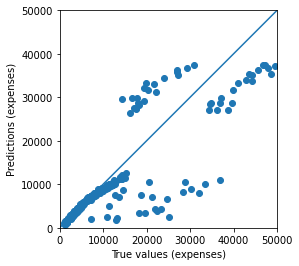

In [13]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(test_dataset).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)
